In [12]:
import pandas as pd
from Bio import SeqIO, AlignIO, Seq
import numpy as np
from collections import Counter
from helper import *
import python_cipres.client as CipresClient

### Extract fasta sequences for the autotrophic rubiscos
Before running this code we need to generate a file called `autotrophic_rubisco_70p.csv` by selecting in ITOL clades that belong to Rubisco types 1,2,2/3,3a,3c,3-like,3b and IV. We replaced sapces in the sequence ID to `_` to match the sequence ID in the fasta files. We take only sequences which are not type IV or type III-b as autotrophic.

In [2]:
uclust_data = pd.read_csv('../output/01_70p_tree/uclust_all_0.7.csv')
uclust_data = uclust_data[uclust_data['Type'] !='S']
uclust_data.loc[uclust_data['Target'] == '*','Target'] = uclust_data.loc[uclust_data['Target'] == '*','Query']
uclust_data['cut Target'] = uclust_data.Target.apply(lambda x: x.split(' ')[0])
#auto_id = [x.replace('\n','') for x in open('../output/01_70p_tree/autotrophic_rubisco_70p.txt').readlines() if x != '\n']
rubisco_types = pd.read_csv('../output/01_70p_tree/rubisco_types_70p.csv')
autotrophic_70p = rubisco_types[~rubisco_types['type'].isin(['IV','IIIb'])]
auto_rubisco = uclust_data.merge(autotrophic_70p, left_on='cut Target', right_on='ID')
autotrophic_rubisco  = auto_rubisco['Query'].values

auto_seq = []
for record in SeqIO.parse('../output/00_100p_tree/uclust_all_1.faa', "fasta"):
    if record.description in autotrophic_rubisco:
        auto_seq.append(record)
!mkdir -p ../output/02_90p_autotrophic_rubisco_tree
with open(r"../output/02_90p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa", "w") as output_handle:
    SeqIO.write(auto_seq, output_handle, "fasta")

In [3]:
auto_rubisco.to_csv('../output/02_90p_autotrophic_rubisco_tree/uclust_all_0.7_with_type.csv')
auto_rubisco.groupby('type')['Query'].nunique()

type
I           36258
II            326
II/III         51
III-like       99
IIIa           95
IIIc           35
unknown        23
Name: Query, dtype: int64

### Cluster sequences using uclust

In [4]:
!../bin/usearch11.0.667_i86linux32 -cluster_fast ../output/02_90p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa -id 0.9 -uc ../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9.uc

usearch v11.0.667_i86linux32, 4.0Gb RAM (16.3Gb total), 8 cores
(C) Copyright 2013-18 Robert C. Edgar, all rights reserved.
https://drive5.com/usearch

License: yinonmoise.baron@weizmann.ac.il

00:00 64Mb    100.0% Reading ../output/02_90p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa
00:00 102Mb   100.0% DF
00:00 102Mb  36887 seqs, 36887 uniques, 36887 singletons (100.0%)
00:00 102Mb  Min size 1, median 1, max 1, avg 1.00
00:00 108Mb   100.0% DB
00:02 167Mb   100.0% 922 clusters, max size 6959, avg 40.0
                                                          
      Seqs  36887 (36.9k)
  Clusters  922
  Max size  6959
  Avg size  40.0
  Min size  1
Singletons  451, 1.2% of seqs, 48.9% of clusters
   Max mem  167Mb
      Time  2.00s
Throughput  18.4k seqs/sec.



### Take only cluster fasta files and create csv file

In [5]:
parse_uclust(infile='../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9.uc',
             fasta='../output/02_90p_autotrophic_rubisco_tree/autotrophic_rubisco_seq.faa',
             outfasta='../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9.faa',
             outfile='../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9.csv'
            )

In [6]:
auto_rub_90p = pd.read_csv('../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9.csv')
auto_rub_90p = auto_rub_90p[auto_rub_90p['Type'] !='S']
auto_rub_90p.loc[auto_rub_90p['Target'] == '*','Target'] = auto_rub_90p.loc[auto_rub_90p['Target'] == '*','Query']

auto_rub90 = auto_rubisco.merge(auto_rub_90p,left_on='Query',right_on='Query')
auto_rub90.to_csv('../output/02_90p_autotrophic_rubisco_tree/uclust_all_0.9_with_type.csv')
auto_rub90.groupby('type')['Target_y'].nunique()

type
I           607
II          109
II/III       29
III-like     60
IIIa         68
IIIc         29
unknown      20
Name: Target_y, dtype: int64

## Create multiple sequence alignment

In [7]:
!../bin/mafft-linux64/mafft.bat ../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9.faa > ../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9.aln

nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..
  901 / 922
done.

Constructing a UPGMA tree (efffree=0) ... 
  920 / 922
done.

Progressive alignment 1/2... 
STEP   464 / 921 
Reallocating..done. *alloclen = 2411
STEP   801 / 921 
Reallocating..done. *alloclen = 3436
STEP   901 / 921  h
Reallocating..done. *alloclen = 4818

done.

Making a distance matrix from msa.. 
  900 / 922
done.

Constructing a UPGMA tree (efffree=1) ... 
  920 / 922
done.

Progressive alignment 2/2... 
STEP   801 / 921 
Reallocating..done. *alloclen = 2458
STEP   901 / 921  h
Reallocating..done. *alloclen = 3950

done.

disttbfast (aa) Version 7.427
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'ma

## Clean MSA to contain only positions with more than 5% coverage (based on Jaffe et al. 2018)

In [8]:
clean_aln(infile='../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9.aln',
          outfile='../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9_trimmed.aln')

ValueError: 1 is not in list

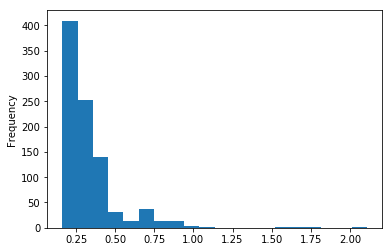

In [70]:
aln = AlignIO.read('../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9_trimmed.aln',format='fasta')
x = []
x2 = []
x3 = []
for i in range(len(aln)):
    x.append(Counter(aln[i,:])['-']/len(aln[i,:]))
    x2.append(len(max(re.compile("(-+-)*").findall(str(aln[i,:].seq)))))
    x3.append(np.mean([len(x) for x in re.compile("(-+-)*").findall(str(aln[i,:].seq))]))
%matplotlib inline
#pd.Series(x).plot.hist(bins=20)
#pd.Series(x2).plot.hist(bins=20)
pd.Series(x3).plot.hist(bins=20)
#pd.Series(x2).plot.hist(bins=np.logspace(np.log10(np.min(x2)),np.log10(np.max(x2)),20),logx=True)

Counter(aln[-1])['-']/len(aln[-1])
import re




In [75]:
seq = SeqIO.parse('../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9.faa',format='fasta')
#[y.id for x,y in zip(aln,seq)][-2]
x4= [len(str(x.seq).replace('-',''))/len(y.seq) for x,y in zip(aln,seq)]
x4[-2]

0.670995670995671

In [9]:
cip = CipresClient.Client(appname='RO',
                    appID='rubisco_phylogeny-49F87B124F3D429FBE12F95E4254DDEA',
                    baseUrl='https://cipresrest.sdsc.edu/cipresrest/v1',
                    username='yinonbaron',
                    password='Mchcav11~')


In [10]:
job = cip.submitJob(vParams={'toolId': 'RAXMLHPC8_REST_XSEDE',
                       'datatype_': 'protein',
                       'runtime_': '160',
                       'select_analysis_': 'fa',
                       'choose_bootstrap_': 'x',
                       'printbrlength_': '1'},
              inputParams={'infile_': '../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9_trimmed.aln'},
              metadata={'statusEmail':'true'})

In [30]:
job = cip.listJobs()[-1]

In [11]:
if cip.getJobStatus(jobHandle=job.jobHandle).isDone():
    !mkdir -p ../output/02_90p_autotrophic_rubisco_tree/RaxML/
    job.downloadResults('../output/02_90p_autotrophic_rubisco_tree/RaxML/')
else:
    print('Job ' + job.jobHandle + ' not finished')

Job NGBW-JOB-RAXMLHPC8_REST_XSEDE-0A58DB8818B246C1A2E71A14BF728C12 not finished


In [2]:
add_type(type_file='../data/jaffe_et_al_2018_rubisco_types.csv',
         seq_file='../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9.csv',
         outfile='../output/02_90p_autotrophic_rubisco_tree/type_legend.txt')

In [2]:
add_kinetic(kinetic_file='../data/flamholz_et_al_2019_kinetically_characterized.faa',
            synth_file='../data/milo_synthetized_rubisco.faa',
            seq_file='../output/02_90p_autotrophic_rubisco_tree/auto_uclust_all_0.9.csv',
            outfile='../output/02_90p_autotrophic_rubisco_tree/kinetic_legend.txt')